In [ ]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

df = pd.read_csv('FinalProjectData.csv')


# 輸出編號標頭
LABEL = 'classNum'

# 資料前處理--> Label encoding : 把每個類別字串 mapping 到某個整數
# 通過LabelEncoder將標籤從String轉換為Integer
le = preprocessing.LabelEncoder()
# 新增 classNum欄位
df[LABEL] = le.fit_transform(df['class'].values.ravel())

# 它將classNum編號為 : jogging --> 0 , run --> 1 , walk --> 2

# 用time每400筆當成1筆，取60%(time % 5 = 2或3或4)為train
df_train = df[(df['time'] % 5) > 1]
# 用time每400筆當成1筆，取40%(time % 5 = 0或1)為test
df_test = df[(df['time'] % 5) <= 1]


print('df_train shape: ', df_train.shape)
print('df_test shape: ', df_test.shape)

# 印出資料的classes
print(list(le.classes_))

# 印出df_train開頭幾筆資料
df_train.head()

df_train shape:  (292265, 7)
df_test shape:  (74165, 7)
['jogging', 'run', 'walk']


,time,gFx,gFy,gFz,TgF,class,classNum
417,1.001001,0.7227,0.9321,-0.3847,1.241,walk,2
418,1.008541,0.7404,0.9284,-0.3897,1.250,walk,2
419,1.009890,0.7559,0.9238,-0.3988,1.258,walk,2
420,1.010402,0.7605,0.9188,-0.3982,1.257,walk,2
421,1.011899,0.7602,0.9126,-0.4112,1.257,walk,2


In [ ]:
import scipy.stats as st
import numpy as np

# 幾筆資料取成1筆資料
TIME_PERIODS = 400
# 每幾筆作為間隔差
STEP_DISTANCE = 40

# train 從366,431 * 80% = 293,144筆 --> 293,144 / 40 = 7,319筆

def create_segments_and_labels(df, time_steps, step, label_name):

	# 特徵: gFx,gFy,gFz,TgF
	N_FEATURES = 4

	segments = []
	labels = []
	for i in range(0,len(df) - time_steps, step):
		gx = df['gFx'].values[i: i + time_steps]
		gy = df['gFy'].values[i: i + time_steps]
		gz = df['gFz'].values[i: i + time_steps]
		tg = df['TgF'].values[i: i + time_steps]

		# 取這time_steps數量當中出現次數最多的標籤
		label = st.mode(df[label_name][i : i + time_steps])[0][0]
		segments.append([gx,gy,gz,tg])
		labels.append(label)

	# 調整segments陣列的shape
	reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1,time_steps,N_FEATURES)
	labels = np.asarray(labels)

	return reshaped_segments, labels



x_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS ,STEP_DISTANCE, LABEL)


print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)


num_time_periods, num_sensors = x_train.shape[1],x_train.shape[2]
num_classes = le.classes_.size

x_train shape:  (7297, 400, 4)
y_train shape:  (7297,)


In [ ]:
from keras.utils import np_utils

x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

# 將二維矩陣的輸入flatten成一維矩陣的輸入(400*4 --> 1600)
input_shape = (num_time_periods * num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('input shape: ', input_shape)
print('x_train shape: ', x_train.shape)

# 將類別向量y_train轉換成二進制(只有0或1)的矩陣類型
y_train = np_utils.to_categorical(y_train, num_classes)
print('y_train shape: ', y_train.shape)

input shape:  1600
x_train shape:  (7297, 1600)
y_train shape:  (7297, 3)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_14 (Reshape)        (None, 400, 4)            0         
                                                                 
 conv1d_18 (Conv1D)          (None, 391, 100)          4100      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 130, 100)         0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 121, 150)          150150    
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 40, 150)          0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 31, 150)         

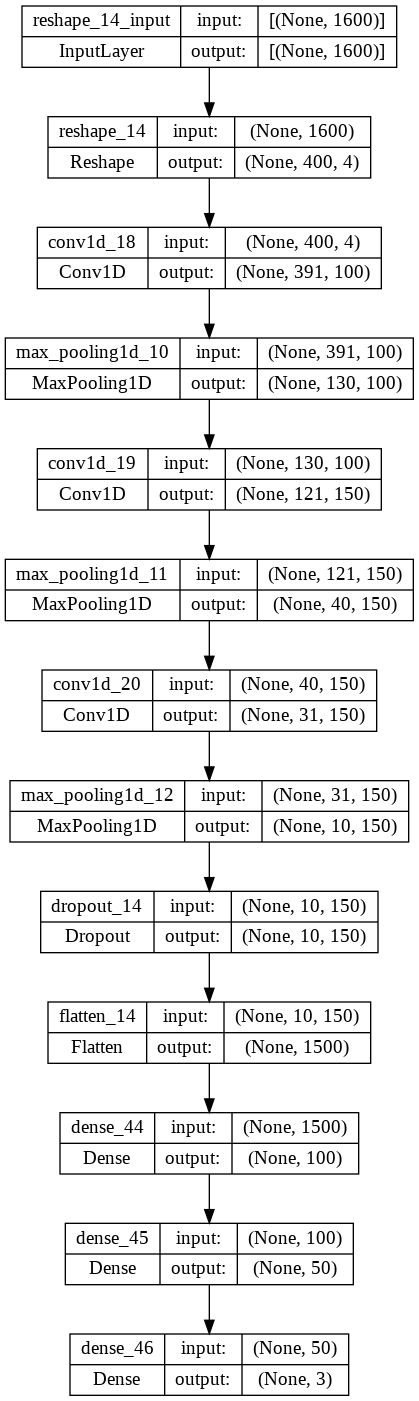

In [ ]:
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Conv1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# 建立model
# Reshape層 --> Convolution層 + AveragePooling層 做三次 --> Dropout層
# Flatten層 --> fully connected network 做三層

model_m = Sequential()
model_m.add(Reshape((num_time_periods,num_sensors), input_shape=(input_shape,)))
# output shape --> (400,4)
model_m.add(Conv1D(filters=100,kernel_size=10,strides=1,activation='sigmoid',input_shape=(num_time_periods,num_sensors)))
# output shape --> (391,100)
model_m.add(MaxPooling1D(3))
# output shape --> (130,100)
model_m.add(Conv1D(filters=150,kernel_size=10,strides=1,activation='relu'))
# output shape --> (121,150)
model_m.add(MaxPooling1D(3))
# output shape --> (40,150)
model_m.add(Conv1D(filters=150,kernel_size=10,strides=1,activation='relu'))
# output shape --> (121,150)
model_m.add(MaxPooling1D(3))
# output shape --> (40,150)

model_m.add(Dropout(0.5))

model_m.add(Flatten())
# output shape --> (1500)

model_m.add(Dense(100,activation='relu'))
model_m.add(Dense(50,activation='relu'))
model_m.add(Dense(num_classes,activation='softmax'))
print(model_m.summary())
plot_model(model_m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.optimizers import SGD
from keras.optimizers import Adam

BATCH_SIZE = 100
EPOCHS = 10

# 訓練

model_m.compile(loss="mean_squared_error",
		optimizer=SGD(lr=0.1),
		metrics=['accuracy'])

history = model_m.fit(x_train,
		        y_train,
	        	batch_size = BATCH_SIZE,
	        	epochs=EPOCHS)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


73/73 [==============================] - 37s 500ms/step - loss: 0.2082 - accuracy: 0.4591
Epoch 2/10
73/73 [==============================] - 36s 496ms/step - loss: 0.1904 - accuracy: 0.5539
Epoch 3/10
73/73 [==============================] - 36s 496ms/step - loss: 0.0962 - accuracy: 0.8169
Epoch 4/10
73/73 [==============================] - 36s 496ms/step - loss: 0.0300 - accuracy: 0.9519
Epoch 5/10
73/73 [==============================] - 38s 516ms/step - loss: 0.0217 - accuracy: 0.9634
Epoch 6/10
73/73 [==============================] - 36s 495ms/step - loss: 0.0179 - accuracy: 0.9693
Epoch 7/10
73/73 [==============================] - 36s 494ms/step - loss: 0.0168 - accuracy: 0.9714
Epoch 8/10
73/73 [==============================] - 36s 496ms/step - loss: 0.0162 - accuracy: 0.9725
Epoch 9/10
73/73 [==============================] - 36s 497ms/step - loss: 0.0152 - accuracy: 0.9745
Epoch 10/10
45/73 [=================>............] - ETA: 14s - loss: 0.0155 - accuracy: 0.9731

In [ ]:
# 印出Accuracy跟Epoch之間的曲線圖
plt.plot(history.history['accuracy'], label='accuracy')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
# 測試

STEP_DISTANCE = 400

x_test, y_test = create_segments_and_labels(df_test,TIME_PERIODS , STEP_DISTANCE, LABEL)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
# 將二維矩陣的輸入flatten成一維矩陣的輸入(400*4 --> 1600)
input_shape = (num_time_periods * num_sensors)
x_test = x_test.reshape(x_test.shape[0], input_shape)
from keras.utils import np_utils
# 將類別向量y_train轉換成二進制(只有0或1)的矩陣類型
y_test = np_utils.to_categorical(y_test, num_classes)

test_loss, test_acc = model_m.evaluate(x_test, y_test, verbose=2)